# Importação de bibliotecas

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import joblib

# Conversão para CSV

In [2]:
dados_excel = pd.read_excel('alugueis_excel.xlsx')
dados_excel.head()

,tipo,localizacao,endereco,area,quarto,banheiro,vagas_garagem,valor_aluguel,condo,iptu
0,Casa,Jardim Colorado,Rua Orlando Lopes,30.0,1,1,1.0,600,NaN,NaN
1,Apartamento,Jardim Tijuca,Rua Mona Lisa,10.0,1,1,1.0,650,NaN,NaN
2,Casa,Tiradentes,Avenida Rouxinol,38.0,1,1,NaN,650,NaN,47.0
3,Apartamento,Centro,Rua Sete de Setembro,10.0,1,1,NaN,680,NaN,65.0
4,Apartamento,Jardim Monte Líbano,Rua José Luiz Pereira,46.0,2,1,NaN,700,NaN,52.0


In [3]:
dados_excel.to_csv("alugueis.csv", index=False)

In [2]:
dados = pd.read_csv("alugueis.csv")
dados

,tipo,localizacao,endereco,area,quarto,banheiro,vagas_garagem,valor_aluguel,condo,iptu
0,Casa,Jardim Colorado,Rua Orlando Lopes,30.0,1,1,1.0,600,NaN,NaN
1,Apartamento,Jardim Tijuca,Rua Mona Lisa,10.0,1,1,1.0,650,NaN,NaN
2,Casa,Tiradentes,Avenida Rouxinol,38.0,1,1,NaN,650,NaN,47.0
3,Apartamento,Centro,Rua Sete de Setembro,10.0,1,1,NaN,680,NaN,65.0
4,Apartamento,Jardim Monte Líbano,Rua José Luiz Pereira,46.0,2,1,NaN,700,NaN,52.0
...,...,...,...,...,...,...,...,...,...,...
422,Casa,Residencial Damha,Rua Ipomeia,305.0,5,5,4.0,16000,905.0,927.0
423,Casa,Residencial Damha,Avenida Marquês de Pombal,85.0,6,7,2.0,17500,1092.0,657.0
424,Casa,Centro,Rua Abrão Júlio Rahe,700.0,6,7,3.0,21000,NaN,1100.0
425,Casa,Residencial Damha,Alameda Recanto das Araras,406.0,3,4,NaN,26000,NaN,NaN


# Limpeza e tratamento dos dados

In [3]:
dados

,tipo,localizacao,endereco,area,quarto,banheiro,vagas_garagem,valor_aluguel,condo,iptu
0,Casa,Jardim Colorado,Rua Orlando Lopes,30.0,1,1,1.0,600,NaN,NaN
1,Apartamento,Jardim Tijuca,Rua Mona Lisa,10.0,1,1,1.0,650,NaN,NaN
2,Casa,Tiradentes,Avenida Rouxinol,38.0,1,1,NaN,650,NaN,47.0
3,Apartamento,Centro,Rua Sete de Setembro,10.0,1,1,NaN,680,NaN,65.0
4,Apartamento,Jardim Monte Líbano,Rua José Luiz Pereira,46.0,2,1,NaN,700,NaN,52.0
...,...,...,...,...,...,...,...,...,...,...
422,Casa,Residencial Damha,Rua Ipomeia,305.0,5,5,4.0,16000,905.0,927.0
423,Casa,Residencial Damha,Avenida Marquês de Pombal,85.0,6,7,2.0,17500,1092.0,657.0
424,Casa,Centro,Rua Abrão Júlio Rahe,700.0,6,7,3.0,21000,NaN,1100.0
425,Casa,Residencial Damha,Alameda Recanto das Araras,406.0,3,4,NaN,26000,NaN,NaN


In [3]:
dados['vagas_garagem'].describe()

count    363.000000
mean       1.674931
std        1.071533
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        7.000000
Name: vagas_garagem, dtype: float64

In [4]:
# Preenchendo os valores ausentes de vagas_garagem com 1
dados['vagas_garagem'] = dados['vagas_garagem'].fillna(1)

In [5]:
# Preenchendo os valores ausentes de condo e iptu com 0
dados['condo'] = dados['condo'].fillna(0)
dados['iptu'] = dados['iptu'].fillna(0)

In [6]:
media_por_grupo = dados.groupby(['quarto', 'banheiro'])['area'].mean().reset_index()  
media_por_grupo.rename(columns={'area': 'area_media'}, inplace=True)

In [7]:
dados = dados.merge(media_por_grupo, on=['quarto', 'banheiro'], how='left') 

In [8]:
dados['area'] = dados['area'].fillna(dados['area_media'])

In [9]:
if dados['area'].isna().any():  
    media_fallback = dados.groupby('quarto')['area'].mean().reset_index()  
    media_fallback.rename(columns={'area': 'area_fallback'}, inplace=True)  
    dados = dados.merge(media_fallback, on='quarto', how='left')  
    dados['area'] = dados['area'].fillna(dados['area_fallback'])  
    dados.drop('area_fallback', axis=1, inplace=True) 

In [10]:
dados.drop('area_media', axis=1, inplace=True) 

In [11]:
dados['area'].isna().sum()

0

In [12]:
dados['area'] = dados['area'].round().astype(int)

In [13]:
dados['eh_condo'] = (dados['condo'] > 0).astype(int)

In [14]:
print(dados['eh_condo'].value_counts()) 

eh_condo
0    259
1    168
Name: count, dtype: int64


In [15]:
dados

,tipo,localizacao,endereco,area,quarto,banheiro,vagas_garagem,valor_aluguel,condo,iptu,eh_condo
0,Casa,Jardim Colorado,Rua Orlando Lopes,30,1,1,1.0,600,0.0,0.0,0
1,Apartamento,Jardim Tijuca,Rua Mona Lisa,10,1,1,1.0,650,0.0,0.0,0
2,Casa,Tiradentes,Avenida Rouxinol,38,1,1,1.0,650,0.0,47.0,0
3,Apartamento,Centro,Rua Sete de Setembro,10,1,1,1.0,680,0.0,65.0,0
4,Apartamento,Jardim Monte Líbano,Rua José Luiz Pereira,46,2,1,1.0,700,0.0,52.0,0
...,...,...,...,...,...,...,...,...,...,...,...
422,Casa,Residencial Damha,Rua Ipomeia,305,5,5,4.0,16000,905.0,927.0,1
423,Casa,Residencial Damha,Avenida Marquês de Pombal,85,6,7,2.0,17500,1092.0,657.0,1
424,Casa,Centro,Rua Abrão Júlio Rahe,700,6,7,3.0,21000,0.0,1100.0,0
425,Casa,Residencial Damha,Alameda Recanto das Araras,406,3,4,1.0,26000,0.0,0.0,0


In [28]:
campo_grande = {
    "Centro": {
            "Centro": ["Centro", "Cidade", "Vila Alta", "Vila General Wolfgrand", "Vila América", "Vila Ilgenfritz", "Vila Clementina", 
                      "Jardim Aclimação", "Vila Bartiria"],
            "São Francisco": ["Vila São Francisco", "Vila Helena", "Vila Anfe", "Vila Cristina", "Vila São Sebastião", "Vila Aprazível", 
                              "Jardim Cidade", "Jardim Brasil", "Vila Alto das Paineiras", "Sanziro Katayama", "Vila São Thomé", 
                              "Vila Capri", "Vila Benjamim", "Vila Esplanada", "Vila São Luís", "Cofermat", "Vila Santa Bárbara", "Cascudo", 
                              "São Francisco"],
            "Cruzeiro": ["Cruzeiro", "Clube Campestre Ypê", "Vila Rosa", "Vila Marman", "Vila Gomes", "Vila Célia", 
                         "Coophagrande (Conjunto Eudes Costa)", "Vila Suíça", "Conjunto Residencial Monte Castelo", "Coophaban"],
            "Jardim dos Estados": ["Jardim dos Estados", "Vila Santa Odete", "Vila Guaraciaba", "Vila Tupaceretan", "Vila Esportiva", 
                                   "Vila XV de Novembro", "Jardim 7 de Setembro", "Vila Mandeta", "Vila São Jorge", "Cachoeira", "Vila Onze", 
                                   "Vila São Gabriel", "Vila Mariana", "Vila Bernardo Goldman", "Vila Isís", "Vila Abdo", 
                                   "Vila Alto Campo de Marte", "Vila Santério", "Vila da Saúde", "Vila Paulistana", "Vila Paraíso", 
                                   "Vila Paraíso Suplemento", "Vila São Elias", "Vila Lia", "Chácara dos Coqueiros", "Vila Rolim", 
                                   "Vila Suburbano", "Vila Sant’ana", "Vila Maria"],
            "Bela Vista": ["Jardim Bela Vista", "Vila Costa Lima", "Jardim Santa Catarina", "Chácara Vendas", "Jardim Nova Era", 
                           "Residencial Village", "Vila Antônio Vendas", "Vila Miguel Couto", "Jardim Alegre", "Chácara Boa Vista",
                           "Villa Di Parma"],
            "Itanhangá": ["Itanhangá Park", "Jardim Piracicaba", "Vila Gatão", "Vila Rosa Pires", "Vila Dr. João Rosa", "Vila Rezende",
                          "Jardim Vista Alegre", "Vila Joselito", "Coophamorena", "Glaucos da Costa Marques"],
            "São Bento": ["Jardim São Bento", "Vila Nova São Bento", "Jardim Guarujá", "Vila Galvão"],
            "Monte Líbano": ["Jardim Monte Líbano", "Vila Santo André", "Jardim de Allah", "Vila Antônio Inácio de Souza"],
            "Glória": ["Vila Glória", "Vila Fortuna", "Vila Eva", "Vila Oriente", "Vila Gaspar", "Vila Taveira", "Vila Sol Nascente", 
                       "Vila Ornelas", "Vila Santa Filomena", "Vila São Miguel", "Vila Castelo", "Vila Jardim Alvorada", "Vila Liberdade", 
                       "Vila Santa Dorothea"],
            "Carvalho": ["Vila Carvalho", "Vila Nossa Senhora de Lourdes", "Vila São José", "Vila Santa Maria", "Vila Quito", 
                         "Vila Carvalho Baís", "Emílio Cury", "Vila São Rafael", "Vila Oliveira", "Vila Americana", "Vila Santa Luiza"],
            "Amambaí": ["Amambaí", "Vila Perseverança", "Vila Maracajú", "Vila Guenka", "Vila São João", "Vila Santo Antônio", "Vila Olga", 
                        "Vila Barão do Rio Branco", "Vila Aurora", "Vila Warde", "Vila Floresta", "Vila Portão de Ferro", "Vila Orpheu Baís", 
                        "Vila São Vicente", "Cohasmat (Sargento Amaral)", "Vila Sargento Amaral"],
            "Cabreúva": ["Cabreúva", "Vila Esplanada", "Vila Feliciana Carolina", "Vila Santa Rosa", "Vila Marisa", "Vila Guarani", 
                         "Vila Independência"],
            "Planalto": ["Vila Planalto", "Vila Soares", "Vila Soares", "Vila São Manoel", "Vila Santa Tereza", "Vila Estephania", 
                         "Vila Alto Sumaré", "Vila Corumbá", "Vila Santos", "Vila Boa Vista", "Monte Verde", "Colinas de Campo Grande", 
                         "Sky Residence"]
            },
    "Segredo": {
        "José Abrão": ["Núcleo Habitacional José Abrão", "Parque dos Laranjais", "Jardim das Paineiras", "Vila Oeste", 
                               "Manoel Taveira", "Núcleo Parque dos Laranjais", "Jardim das Virtudes"],
        "Nasser": ["Vila Nasser", "Santa Luzia", "Vila Cox", "Jardim Alto São Francisco", "Jardim das Acácias", "Vila Lili", 
                    "Parque Residencial Azaléia", "Jardim Veneza", "Loteamento Municipal Dr. Miguel Vieira Ferreira", 
                    "Jardim Fluminense", "Nossa Senhora das Graças", "Vila Nilza", "Jardim Paquetá", "Coophasul", 
                    "Vila Nossa Senhora Aparecida", "Vila Neuza", "Vila Marli", "Vila Novo Horizonte", "Bosque da Saúde", 
                    "São Caetano", "Jardim Paradiso", "Jardim Monte Alto", "Loteamento Dona Dedé", "Setvillage I", 
                    "Setvillage II", "Água Limpa Park", "Residencial Carajás", "Morada dos Deuses", "Residencial Alto Tamandaré", 
                    "Residencial Recanto do Cerrado", "Bom Retiro", "Residencial Tolentino", "Jardim da Mooca", 
                    "Vila Nossa Senhora das Graças", "Residencial Maria Neves", "Loteamento Maria Neves"],
        "Seminário": ["Bairro Seminário", "Jardim Seminário", "Jardim Seminário II", "Vila Santa Lúcia", "Vila Jardim Maria Amélia", 
                      "Vila Nossa Senhora da Conceição", "Jardim Oracília", "Vila Dalila", "Vila Leda", "Vila Antonieta", 
                      "Vila São Roque", "Vila Saraiva", "Portal do Gramado", "São Benedito", "Lagoa da Cruz", "Vila Lídia", "North Park", 
                      "Residencial Novo Seminário"],
        "Monte Castelo": ["Monte Castelo", "Residencial Vale do Sol I", "Residencial Vale do Sol II", "Residencial Vale do Sol III", 
                          "Residencial Indaiá", "Jardim São Paulo", "Vila São João Bosco", "Residencial Otávio Pécora", 
                          "Jardim Bosque de Avilan", "Center Park", "Jardim Aruba", "Loteamento Campo Dourado", 
                          "Loteamento Costa Verde", "Praia da Urca", "Residencial Gabura"],
        "Mata do Segredo": ["Jardim das Cerejeiras", "Jardim Campo Novo", "Jardim Presidente", "Jardim Campo Belo", 
                            "Loteamento Municipal Salinas", "Loteamento Municipal Cristaldo", "Núcleo das Cerejeiras", 
                            "Jardim Nascente do Segredo", "Residencial Gama", "Arnaldino da Silva", "Treviso", "Mata do Segredo"],
        "Coronel Antonino": ["Coronel Antonino", "Estrela do Sul", "Jardim Imperial", "Jardim Mirasol", 
                             "Eldorado", "Vila Califórnia", "Vila Triângulo", "Guanabara", "Morada Verde", 
                             "Conjunto Residencial Nova Olinda", "Jardim Campo Verde", "Loteamento Municipal Raízes", 
                             "Favela Rio de Janeiro", "Favela Guatambu", "Beco da Liberdade", "Favela Nacional", 
                             "Loteamento Municipal Jaburu", "Núcleo Morada Verde", "Parque Izabel Garden’s", "Jardim Talismã", 
                             "Residencial Atlântico Sul", "Loteamento Morada do Sossego", "Jardim Barcelona", "Morada do Sossego", 
                             "Morada do Sossego II", "Recanto Pantaneiro", "Villa Ravenna", "Villa Ravenna II", "Ary Abussafi de Lima", 
                             "Gregório Correa", "Vila Ravenna", "Vila Ravenna II"],
        "Nova Lima": ["Nova Lima", "Jardim Anache", "Jardim Columbia", "Loteamento Municipal Pereira Borges", "Favela Jardim Anache", 
                      "área F", "Jardim Vida Nova", "Vida Nova II", "Tarsila do Amaral", "Vida Nova III", "José Prates", 
                      "Coriolando da Silva Correa I", "Coriolando da Silva Correa II", "José Tavares do Couto", 
                      "Oscar Salazar Moura da Cruz, Parque Iguatemi"]
    },
    "Prosa": {
        "Autonomista": ["Jardim Autonomista", "Jardim Autonomista II", "Jardim Autonomista III", "Jardim Giocondo Orsi", 
                        "Jardim Giocondo Orsi II", "Monte Carlo", "Vila Monte Carlo", "Vila Rica", "Vila Taquari", "Vila Cacique", "Vila Pagé", 
                        "Jardim Vitrine", "Vila Orsi", "Vila Cruzeiro do Sul", "Loteamento Petit Park", "Coophabanco", 
                        "Vila Boa Esperança", "Coophafé"],
        "Santa Fé": ["Santa Fé", "Vila Santos Gomes", "Conjunto Residencial Nova Ipanema", "Vivendas do Bosque", "Royal Park"],
        "Chácara Cachoeira": ["Chácara Cachoeira", "Chácara Cachoeira II", "Cachoeirinha", "Jatiúca Park", "Vila Miguel Couto", 
                              "Vila Manoel da Costa Lima", "Jardim Umuarama", "Cidade Jardim", "San Marino Park", "Nahima Park", 
                              "Altos da Afonso Pena", "Parque dos Poderes"],
        "Carandá": ["Carandá Bosque", "Carandá Bosque II", "Carandá Bosque III", "Golden Gate Park", "Portal Itayara", "Vila do Polonês", 
                    "Tayamã Park", "Vila Nascente", "Loteamento Copacabana", "Loteamento Municipal Mário de Andrade", "Residencial Itacolomi", 
                    "Tropical Park", "Loteamento Residencial Via Park", "Residencial Via Park Itália"],
        "Margarida": ["Vila Margarida", "Vila Lucinda", "Vila Catarina", "Vila Catarina II", "Vila Carolina", "Jardim Marabá", 
                      "Loteamento Municipal Joaquim Euzébio", "Loteamento Municipal Guaicurus", "Loteamento Municipal Verde Brasil", 
                      "Núcleo Marabá", "Loteamento Municipal Paulo VI"],
        "Mata do Jacinto": ["Mata do Jacinto", "Conjunto Mata do Jacinto", "Favela do Limão", "Loteamento Municipal Ceasa", 
                            "Loteamento Municipal Nazaré", "Loteamento Abaeté", "Loteamento Sóter", "Residencial Sóter"],
        "Novos Estados": ["Parque dos Novos Estados", "Jardim Montevidéu", "Conjunto Residencial Novo Amazonas",
                          "Conjunto Residencial Nova Bahia", "Nova Bahia", "Conjunto Residencial Novo Pernambuco", 
                          "Conjunto Residencial Novo Rio Grande do Sul", "Conjunto Residencial Novo Maranhão", 
                          "Conjunto Residencial Novo Sergipe", "Conjunto Residencial Novo São Paulo", 
                          "Conjunto Residencial Novo Alagoas", "Conjunto Residencial Novo Minas Gerais", 
                          "Conjunto Residencial Novo Paraná", "Jardim Jacarandá", "Alphaville Campo Grande", 
                          "Alphaville Campo Grande II", "Alphaville Campo Grande III", "Alphaville Campo Grande IV", 
                          "Terras Alpha Campo Grande"],
        "Estrela Dalva": ["Jardim Estrela Dalva", "Jardim Estrela Dalva I, Jardim Estrela Dalva II, Jardim Estrela Dalva III, Taquaral Bosque"],
        "Veraneio": ["Jardim Veraneio", "Vila Futurista", "Vila Danúbio Azul", "Jardim Tayana", "Vila Abdalla", "Desbarrancado", 
                     "Jardim Arco-Íris", "Loteamento Bosque da Esperança", "Beirute Residence Park", "Bosque da Esperança II"],
        "Chácara dos Poderes": ["Chácara dos Poderes", "Jardim Pinheiros", "Jardim Cabral", "Vila Telma", "Vila Raquel", "Vila Sônia"],
        "Noroeste": ["Jardim Noroeste", "Loteamento Nova Serrana", "Serraville", "Residencial Shalom"]
    },
    "Bandeira": {
        "Jardim Paulista": ["Jardim Paulista", "Vila Progresso", "Paranaense"],
        "TV Morena": ["Jardim TV Morena"],
        "Vilasboas": ["Vila Vilasboas", "Vila Vilas Boas", "Jardim Alegre", "Vila Portinho Frederico Pache", "Indiana Park", 
                      "Jardim Mansur", "Jardim Auxiliadora", "Jardim Ipanema", "Parque Dallas", "Residencial Vila Olímpica", 
                      "Villas Park Residence", "Amantini Residence"],
        "São Lourenço": ["Jardim São Lourenço", "Jardim Ibirapuera", "Vila Almeida Lima", "Vila Zoe"],
        "Tiradentes": ["Tiradentes", "Residencial Nova Tiradentes", "Jardim Flamboyant", "Jardim Flamboyant II", 
                       "Parque Residencial Arnaldo Estevão de Figueiredo", "Parque Residencial Arnaldo Estevão de Figueiredo II", 
                       "Loteamento Municipal Dalva de Oliveira", "Loteamento Municipal Dalva de Oliveira II", "Loteamento Municipal Cavan", 
                       "Núcleo Tiradentes", "Regina", "Residencial Itatiaia", "Vila Jardim São Bernardo", "Jardim Vitória", 
                       "Parque Residencial Anhembi", "Loteamento Portobello", "Loteamento Marçal de Souza", "Jardim Cristo Redentor", 
                       "Loteamento Estrela Parque", "Jardim São Judas Tadeu", "Jardim Jerusalém", "Jardim Itatiaia"],
        "Maria Aparecida Pedrossian": ["Parque Residencial Maria Aparecida Pedrossian", "Panorama", "Vivendas do Parque", 
                                       "Jardim Samambaia", "Residencial Oiti", "Núcleo Panorama", 
                                       "Parque Residencial Damha", "Parque Residencial Damha II", "Parque Residencial Damha III",
                                       "Parque Residencial Damha IV", "Residencial Damha", "Residencial Damha II", "Residencial Damha III",
                                       "Residencial Damha IV"],
        "Rita Vieira": ["Parque Residencial Rita Vieira", "Parque Rita Vieira", "Vila Dom Pedrito", "Vila Morumbi", "Coopharádio", 
                        "Chácara José Antônio Pereira", "Jardim Lagoa Dourada", "Jardim Nossa Senhora do Perpétuo Socorro", "Jardim Itamaracá", 
                        "Jardim Anhanguera", "Jardim Águas Vivas"],
        "Carlota": ["Vila Carlota", "Vila Ieda", "Jardim Itapema"],
        "Dr. Albuquerque": ["Vila Dr. Albuquerque", "Vila Albuquerque", "Vila Olinda", "Vila Maciel"],
        "Universitário": ["Universitário", "Residencial Betaville", "Vila Concórdia", "Vila Santo Eugênio", "Jardim Ametista", 
                          "Jardim Tropical", "Pequena Flor I", "Jardim das Perdizes", "Recanto das Palmeiras", "Jardim Campo Limpo", 
                          "Núcleo Habitacional Recanto dos Rouxinóis", "Jardim Moema", "Sitiocas Alvorada", "Jardim Campina Verde", 
                          "Jardim Campo Alto", "Jardim Pacaembu", "Núcleo Campina Verde", "Jardim Indianápolis", "Vila Julieta", 
                          "Jardim Antares", "Edson Brito Garcia", "Loteamento Volpe", "Loteamento Volpe II"],
        "Moreninha": ["Núcleo Habitacional Moreninha I", "Núcleo Habitacional Moreninha II", "Núcleo Habitacional Moreninha III", 
                      "Loteamento Moreninha IV", "Chácara Novo Horizonte", "Jardim Santa Felicidade", "Vila Cidade Morena", 
                      "Loteamento Municipal Ribeira", "Jardim Gramado", "Jardim Nova Capital", "Jardim Nova Jerusalém", 
                      "Jardim do Córrego", "Residencial Terra dos Pequis", "Paraíso do Lageado", "Vila Moreninha", "Vila Moreninha II"]
    },
    "Anhanduizinho": {
        "Taquarussu": ["Jardim Taquarussu", "Cohafama", "Vila Santo Afonso", "Vila Afonso Pena", "Vila Afonso Pena Júnior", "Vila Itamarati"],
        "Joquey Club": ["Vila Jardim Jockey Club", "Vila Marcos Roberto", "Vila Bom Jesus", "Vila Santa Amélia Baís", 
                        "Residencial Santa Celina", "Jardim Jockey Club"],
        "América": ["Jardim América", "Vila Jardim América", "Vila Valparaíso"],
        "Piratininga": ["Vila Piratininga", "Jardim Nhanhá", "Promorar", "Vila Ipiranga", "Núcleo Piratininga", "Vila Getúlia Barbosa", 
                        "Vitta Bella"],
        "Jacy": ["Jardim Jacy", "Vila Nova Bandeirantes"],
        "Guanandi": ["Guanandi", "Favela Dona Neta", "Favela Núcleo Guanandi I"],
        "Aero Rancho": ["Aero Rancho", "Núcleo Habitacional Aero Rancho", "Núcleo Habitacional Aero Rancho II", 
                        "Núcleo Habitacional Aero Rancho III", "Núcleo Habitacional Aero Rancho IV", "Núcleo Habitacional Aero Rancho V", 
                        "Jardim das Hortênsias"],
        "Parati": ["Jardim Parati", "Jardim Parati II", "Granja Bandeira", "Loteamento Alto da Boa Vista", "Jardim das Nações", 
                   "Conjunto Parati", "Conjunto Parati II"],
        "Pioneiros": ["Pioneiros", "Jardim Colonial", "Residencial do Lago", "Vila Adelina", "Vila Jardim Pioneiros", "Vila Santa Branca", 
                      "Jardim Santa Úrsula", "Recanto das Andorinhas", "Jardim das Mansões", "Universitárias", 
                      "Conjunto Habitacional Jardim Anápolis", "Jardim Rubiácea", "Jardim Jane", "Jardim Botafogo", "Jardim Morenão", 
                      "Jardim Vicentino", "Jardim Roselândia", "Residencial Botafogo", "Parque Residencial Lisboas", "Jardim Botânico", 
                      "Jardim Botânico II", "Jardim Agulhas Negras", "Porto Galo", "Residencial Geraldo Correa da Silva"],
        "Alves Pereira": ["Vila Alves Pereira", "Universitário Seção D", "Jardim Monumento", "Vila Antunes", "Parque do Trabalhador", 
                          "Residencial João Scarano", "Jardim Colibrí", "Jardim Colibri", "Jardim Colibri II", 
                          "Núcleo Habitacional Universitárias I", "Núcleo Habitacional Universitárias II", "Jardim Macapá", 
                          "Loteamento Municipal Alan Soares", "Núcleo Colibri II", "Núcleo Alves Pereira", "Jardim Nashville", 
                          "Vila Clélia", "Loteamento Porto Seguro", "Residencial Ilhéus", "Cidade Nova"],
        "Centenário": ["Jardim Centenário", "Jardim Monte Alegre", "Carlinda Pereira Contar", "Vila Nogueira", "Vila Amapá", "Vila Aimoré", 
                       "Vila Aimoré II", "Parque Residencial Iracy Coelho Netto", "Parque Residencial Iracy Coelho Netto II", 
                       "Parque Residencial Iracy Coelho Netto III", "Núcleo Centenário", "Núcleo Vila Nogueira", "Jardim Pênfigo", 
                       "Residencial Vila Bela", "Residencial Ouro Preto", "Jardim Manaíra", "Jardim Monterey", "Jardim Radialista", 
                       "Loteamento Residencial Cedrinho", "Jardim das Princesas I", "Jardim das Princesas II", "Vila Áurea"],
        "Lageado": ["Parque do Lageado", "Loteamento Municipal Dom Antônio Barbosa", "Parque do Sol", "Jardim Colorado", 
                    "Residencial José Teruel Filho", "Parque dos Sabiás"],
        "Los Angeles": ["Los Angeles", "Jardim Los Angeles", "Jardim Sumatra", "Jardim Morada do Sol", "Jardim Uirapuru", 
                        "Loteamento Vespasiano Martins", "Residencial Terra Morena"],
        "Centro-Oeste": ["Jardim Centro Oeste", "Jardim Marajoara", "Jardim Bálsamo", "Jardim Campo Nobre", "Jardim das Macaúbas", 
                         "Jardim das Meninas", "Loteamento Municipal Brandão", "Núcleo Jardim das Macaúbas", "Jardim Canguru", 
                         "Jardim Paulo Coelho Machado", "Parque Novo Século", "Jardim Mário Covas", "Varandas do Campo"]
    },
    "Lagoa": {
        "Taveirópolis": ["Vila Taveirópolis", "Santos Dumont", "Vila Belo Horizonte"],
        "Bandeirantes": ["Vila Bandeirantes", "Coophavila", "Desmembramento Cornelas", "Vila Jurema", "Vila Bandeirante"],
        "Caiçara": ["Caiçara", "Vila dos Marimbas", "Vila Jardim Anahy", "Vila Maringá"],
        "União": ["União", "Parque Residencial União", "Parque Residencial União II", "Residencial Oliveira", "Residencial Oliveira I", 
                  "Residencial Oliveira II", "Residencial Oliveira III", "Residencial das Flores", "Parque Residencial dos Girassóis"],
        "Leblon": ["Jardim Leblon", "Vila Jussara", "Conjunto Habitacional Bonança", "Jardim Europa", "Coophamat", "Jardim da Lapa", 
                   "Desmembramento Flório Alcebíades Brandão", "Jardim Antarctica", "Vila Ouro Fino", "Jardim Tatiana", 
                   "Vila Ospampas", "Loteamento Bonjardim", "Núcleo Habitacional Buriti", "Alto Leblon", "Jardim Bonança", "Vila Flório"],
        "São Conrado": ["Jardim São Conrado", "Jardim Santa Emília", "Loteamento Municipal Interpraia", "Vila Major Juares", 
                        "Residencial Aquárius I", "Residencial Aquárius II", "Residencial Figueiras do Parque"],
        "Tijuca": ["Jardim Tijuca", "Jardim Tijuca II", "Jardim dos Boggi", "Vila Vilma", "São Pedro", "Jardim Verdes Mares", 
                   "Residencial Barra da Tijuca", "Residencial Barra da Tijuca II"],
        "Caiobá": ["Portal Caiobá", "Portal Caiobá II", "Rancho Alegre II", "Vila Fernanda", "Rivieira Park", "Jardim Rancho Alegre I", 
                   "Bela Laguna", "Loteamento Bela Laguna", "Loteamento Rancho Alegre", "Loteamento Rancho Alegre II"],
        "Batistão": ["Jardim Batistão", "São Jorge da Lagoa", "Jardim Mato Grosso", "Conjunto Residencial Serra Azul", "Lagoa Park", 
                     "Jardim Villa Lobos", "Jardim Villa Lobos II"],
        "Coophavila II": ["Coophavila II", "Jardim Vila Kellem", "Jardim Ouro Verde", "Favela Tarumã"],
        "Tarumã": ["Jardim Tarumã", "Conjunto Residencial Tarumã", "Portal das Laranjeiras", "Jardim Sol Poente", "Jardim Corcovado", 
                   "Vila Jandaia", "Arapongas"]
    },
    "Imbirussu": {
        "Sobrinho": ["Vila Sobrinho", "Vila Acrópolis", "Vila Santa Rita", "Vila Rosalina", "Vila Nossa Senhora Auxiliadora", "Cophaco", 
                     "Parque dos Ipês", "Jardim Leonidia", "Coopermat", "Vila Alba", "Vila Espanhola", "Jardim Ipanema", 
                     "Vila Duque de Caxias", "Vila Cinamomo", "Lar do Trabalhador", "Residencial Parque dos Flamingos", "Vila Aviação", 
                     "Parque São Domingos", "Vila Oeste", "Loteamento Papa João Paulo II", "Sobrinho"],
        "Santo Amaro": ["Vila Santo Amaro", "Vila Jardim Beija-Flor", "Parque dos Laranjais", "Manoel Taveira", "Santa Carmélia", 
                        "Jardim Itapuã", "Coophatrabalho", "Vila Dr. Jair Garcia", "Jardim Canadá", "Vila São Marcos", "Vila Almeida", 
                        "Vila Palmira", "Jardim Mandala", "Residencial Sírio Libanês I", "Residencial Sírio Libanês II", 
                        "Jardim das Virtudes", "Residencial Hugo Rodrigues"],
        "Santo Antônio": ["Santo Antônio", "Jardim Imá", "Vila Nova", "Loteamento Municipal Jaguaribe", "Vila Doriza", 
                          "Jardim Petrópolis", "Vila Bosque da Saudade", "Vila Coutinho", "Vila Sílvia Regina"],
        "Panamá": ["Jardim Panamá", "Jardim Panamá II", "Jardim Panamá III", "Jardim Panamá IV", "Jardim Panamá V", "Jardim Panamá VI", 
                   "Parque Residencial dos Bancários", "Residencial Sagarana", "Jardim Aroeira", "Recanto dos Pássaros", 
                   "Jardim do Zé Pereira", "Residencial Ana Maria do Couto", "Parque Residencial Bellinate", "Residencial Búzios",
                   "Portal do Panamá", "Jardim Mathilde", "Bosque das Araras", "Panamá"],
        "Popular": ["Jardim das Reginas", "Loteamento Municipal Macaé", "Jardim Sayonara", "Jardim Pantanal", "Santa Mônica", 
                    "Jardim Aeroporto", "Jardim Itália", "Bosque Santa Mônica", "Bosque Santa Mônica II", "Vila Romana"],
        "Nova Campo Grande": ["Nova Campo Grande", "Vila Eliane", "Vila Serradinho", "Jardim Carioca", "Residencial Nelson Trad", 
                              "Vila Nova Campo Grande"],
        "Núcleo Industrial": ["Núcleo Industrial", "Jardim Inápolis", "Vila Manoel Secco Thomé", "Vila Entroncamento", 
                              "Pólo Empresarial Oeste", "Morada Imperial"]
    }
}


In [17]:
dados.loc[[48, 88], 'localizacao'] = 'União'

In [25]:
dados.loc[167, 'localizacao'] = "Loteamento Portobello"

In [27]:
dados.loc[391, 'localizacao'] = "Royal Park"

In [29]:
vila_para_regiao_bairro = {}

for regiao, bairros in campo_grande.items():
    for bairro, vilas in bairros.items():
        for vila in vilas:
            vila_para_regiao_bairro[vila.lower()] = (regiao, bairro)

def buscar_localizacao(vila):
    if pd.isna(vila):
        return None, None
    
    vila = str(vila).strip().lower()
    return vila_para_regiao_bairro.get(vila, (None, None))

dados[['regiao', 'bairro']] = dados['localizacao'].apply(
    lambda x: pd.Series(buscar_localizacao(x))
)

In [30]:
dados[['localizacao', 'endereco', 'regiao', 'bairro']]

,localizacao,endereco,regiao,bairro
0,Jardim Colorado,Rua Orlando Lopes,Anhanduizinho,Lageado
1,Jardim Tijuca,Rua Mona Lisa,Lagoa,Tijuca
2,Tiradentes,Avenida Rouxinol,Bandeira,Tiradentes
3,Centro,Rua Sete de Setembro,Centro,Centro
4,Jardim Monte Líbano,Rua José Luiz Pereira,Centro,Monte Líbano
...,...,...,...,...
422,Residencial Damha,Rua Ipomeia,Bandeira,Maria Aparecida Pedrossian
423,Residencial Damha,Avenida Marquês de Pombal,Bandeira,Maria Aparecida Pedrossian
424,Centro,Rua Abrão Júlio Rahe,Centro,Centro
425,Residencial Damha,Alameda Recanto das Araras,Bandeira,Maria Aparecida Pedrossian


In [31]:
dados

,tipo,localizacao,endereco,area,quarto,banheiro,vagas_garagem,valor_aluguel,condo,iptu,eh_condo,regiao,bairro
0,Casa,Jardim Colorado,Rua Orlando Lopes,30,1,1,1.0,600,0.0,0.0,0,Anhanduizinho,Lageado
1,Apartamento,Jardim Tijuca,Rua Mona Lisa,10,1,1,1.0,650,0.0,0.0,0,Lagoa,Tijuca
2,Casa,Tiradentes,Avenida Rouxinol,38,1,1,1.0,650,0.0,47.0,0,Bandeira,Tiradentes
3,Apartamento,Centro,Rua Sete de Setembro,10,1,1,1.0,680,0.0,65.0,0,Centro,Centro
4,Apartamento,Jardim Monte Líbano,Rua José Luiz Pereira,46,2,1,1.0,700,0.0,52.0,0,Centro,Monte Líbano
...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,Casa,Residencial Damha,Rua Ipomeia,305,5,5,4.0,16000,905.0,927.0,1,Bandeira,Maria Aparecida Pedrossian
423,Casa,Residencial Damha,Avenida Marquês de Pombal,85,6,7,2.0,17500,1092.0,657.0,1,Bandeira,Maria Aparecida Pedrossian
424,Casa,Centro,Rua Abrão Júlio Rahe,700,6,7,3.0,21000,0.0,1100.0,0,Centro,Centro
425,Casa,Residencial Damha,Alameda Recanto das Araras,406,3,4,1.0,26000,0.0,0.0,0,Bandeira,Maria Aparecida Pedrossian


In [32]:
dados['valor_total'] = dados['valor_aluguel'] + dados['condo'] + dados['iptu']

In [33]:
dados

,tipo,localizacao,endereco,area,quarto,banheiro,vagas_garagem,valor_aluguel,condo,iptu,eh_condo,regiao,bairro,valor_total
0,Casa,Jardim Colorado,Rua Orlando Lopes,30,1,1,1.0,600,0.0,0.0,0,Anhanduizinho,Lageado,600.0
1,Apartamento,Jardim Tijuca,Rua Mona Lisa,10,1,1,1.0,650,0.0,0.0,0,Lagoa,Tijuca,650.0
2,Casa,Tiradentes,Avenida Rouxinol,38,1,1,1.0,650,0.0,47.0,0,Bandeira,Tiradentes,697.0
3,Apartamento,Centro,Rua Sete de Setembro,10,1,1,1.0,680,0.0,65.0,0,Centro,Centro,745.0
4,Apartamento,Jardim Monte Líbano,Rua José Luiz Pereira,46,2,1,1.0,700,0.0,52.0,0,Centro,Monte Líbano,752.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,Casa,Residencial Damha,Rua Ipomeia,305,5,5,4.0,16000,905.0,927.0,1,Bandeira,Maria Aparecida Pedrossian,17832.0
423,Casa,Residencial Damha,Avenida Marquês de Pombal,85,6,7,2.0,17500,1092.0,657.0,1,Bandeira,Maria Aparecida Pedrossian,19249.0
424,Casa,Centro,Rua Abrão Júlio Rahe,700,6,7,3.0,21000,0.0,1100.0,0,Centro,Centro,22100.0
425,Casa,Residencial Damha,Alameda Recanto das Araras,406,3,4,1.0,26000,0.0,0.0,0,Bandeira,Maria Aparecida Pedrossian,26000.0


In [34]:
dados.to_csv("alugueis_dados_tratados.csv", index=False)

# Análise Exploratória

In [2]:
df = pd.read_csv("alugueis_dados_tratados.csv")

In [6]:
# Configuração do estilo
sns.set_theme(style="whitegrid")
plt.rcParams['font.size'] = 12
cores = sns.color_palette("Blues_r", n_colors=10)
azuis = ['#1f77b4', '#4c94c0', '#78b0cc', '#a4cdd8', '#d0e9e4']

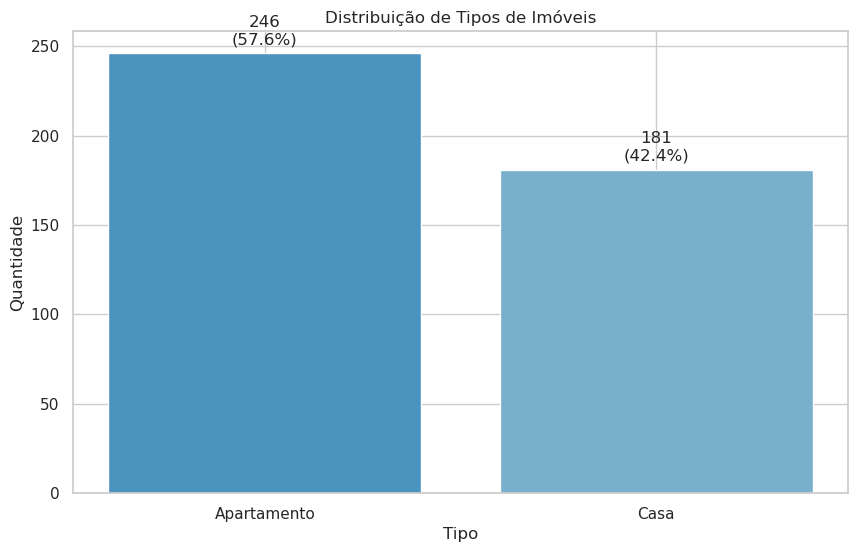

In [7]:
# 1. Distribuição dos Tipos de Imóveis
plt.figure(figsize=(10, 6))
tipo_counts = df['tipo'].value_counts()
plt.bar(tipo_counts.index, tipo_counts.values, color=azuis[1:3])
plt.title('Distribuição de Tipos de Imóveis')
plt.ylabel('Quantidade')
plt.xlabel('Tipo')
for i, v in enumerate(tipo_counts.values):
    plt.text(i, v + 5, f"{v}\n({v/tipo_counts.sum()*100:.1f}%)", ha='center')
plt.show()

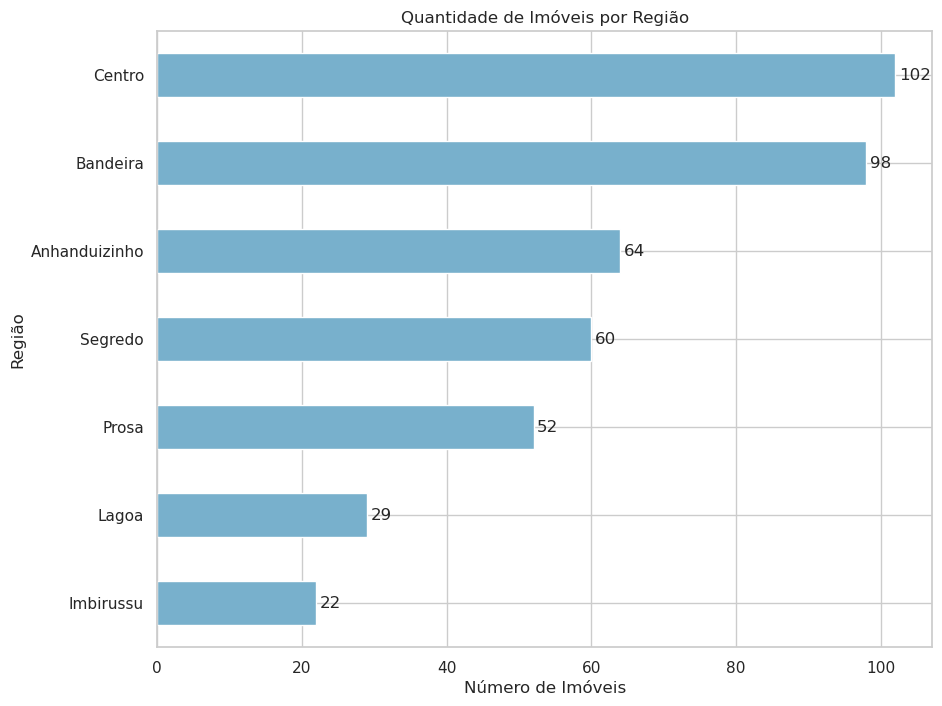

In [8]:
# 2. Distribuição das Regiões
plt.figure(figsize=(10, 8))
regiao_counts = df['regiao'].value_counts().sort_values()
regiao_counts.plot(kind='barh', color=azuis[2])
plt.title('Quantidade de Imóveis por Região')
plt.xlabel('Número de Imóveis')
plt.ylabel('Região')
for i, v in enumerate(regiao_counts.values):
    plt.text(v + 0.5, i, str(v), va='center')
plt.show()

/home/leandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


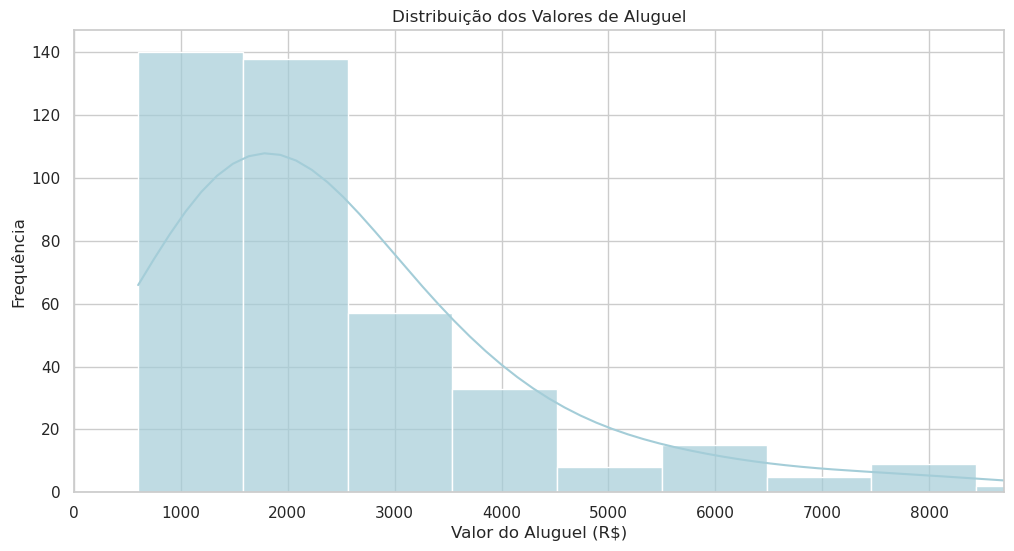

In [9]:
# 3. Distribuição dos Valores de Aluguel
plt.figure(figsize=(12, 6))
sns.histplot(df['valor_aluguel'], bins=30, kde=True, color=azuis[3], alpha=0.7)
plt.title('Distribuição dos Valores de Aluguel')
plt.xlabel('Valor do Aluguel (R$)')
plt.ylabel('Frequência')
plt.xlim(0, df['valor_aluguel'].quantile(0.95))
plt.show()

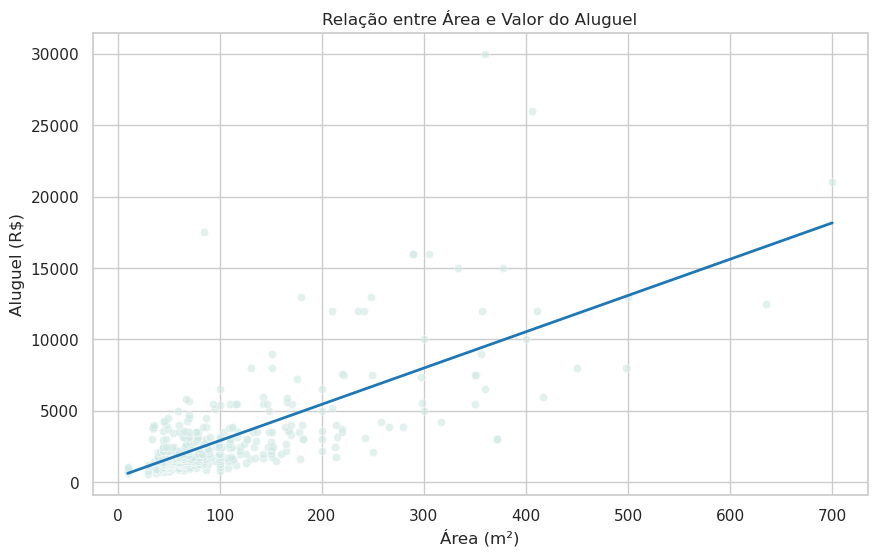

In [10]:
# 4. Relação entre Área e Valor do Aluguel
plt.figure(figsize=(10, 6))
sns.scatterplot(x='area', y='valor_aluguel', data=df, color=azuis[4], alpha=0.6)
plt.title('Relação entre Área e Valor do Aluguel')
plt.xlabel('Área (m²)')
plt.ylabel('Aluguel (R$)')
plt.plot(np.unique(df['area']), 
         np.poly1d(np.polyfit(df['area'], df['valor_aluguel'], 1))(np.unique(df['area'])), 
         color=azuis[0], linewidth=2)
plt.show()

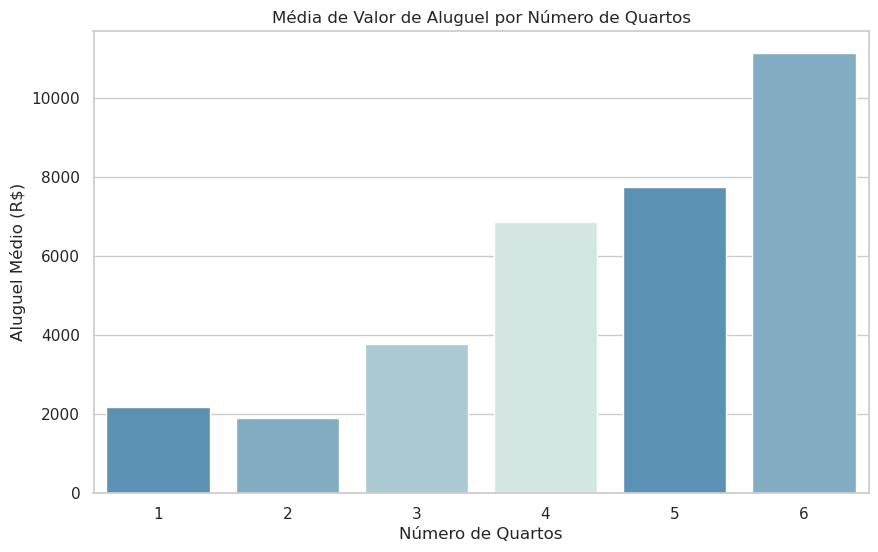

In [11]:
# 5. Quantidade de Quartos vs Valor do Aluguel
plt.figure(figsize=(10, 6))
quarto_aluguel = df.groupby('quarto')['valor_aluguel'].mean().reset_index()
sns.barplot(x='quarto', y='valor_aluguel', data=quarto_aluguel, palette=azuis[1:5])
plt.title('Média de Valor de Aluguel por Número de Quartos')
plt.xlabel('Número de Quartos')
plt.ylabel('Aluguel Médio (R$)')
plt.show()

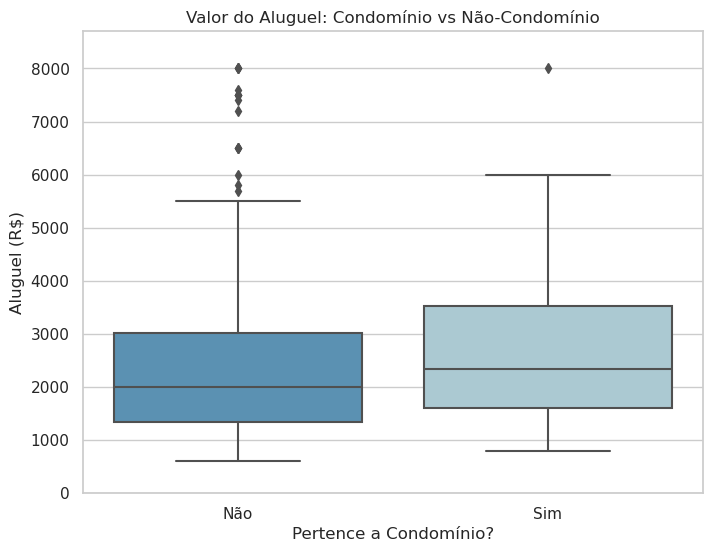

In [12]:
# 6. Móvel estar em um Condomínio vs Valor do Aluguel
plt.figure(figsize=(8, 6))
sns.boxplot(x='eh_condo', y='valor_aluguel', data=df, palette=[azuis[1], azuis[3]])
plt.title('Valor do Aluguel: Condomínio vs Não-Condomínio')
plt.xlabel('Pertence a Condomínio?')
plt.ylabel('Aluguel (R$)')
plt.xticks([0, 1], ['Não', 'Sim'])
plt.ylim(0, df['valor_aluguel'].quantile(0.95))
plt.show()

/home/leandro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


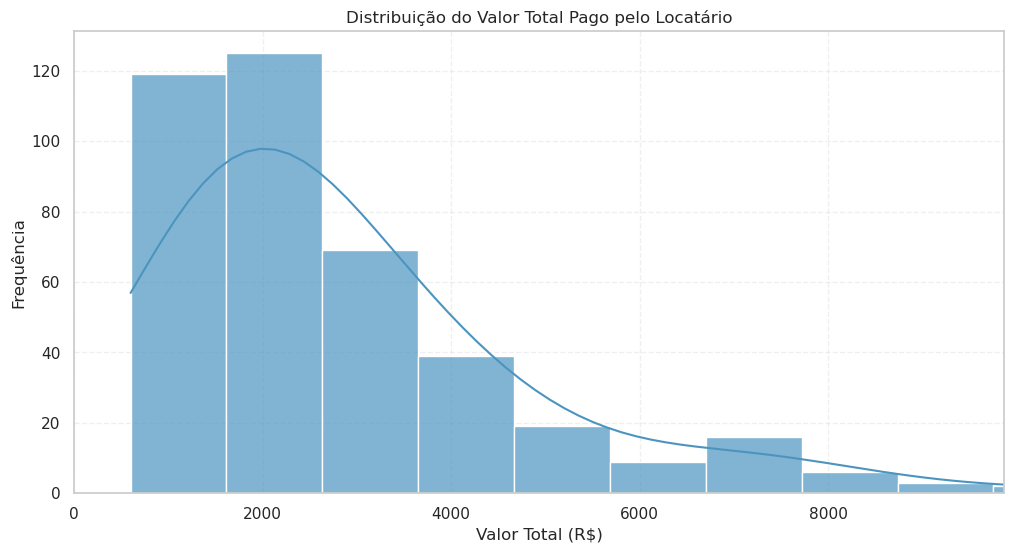

In [13]:
# 7. Distribuição do Valor Total
plt.figure(figsize=(12, 6))
sns.histplot(df['valor_total'], bins=30, kde=True, color='#4c94c0', alpha=0.7)
plt.title('Distribuição do Valor Total Pago pelo Locatário')
plt.xlabel('Valor Total (R$)')
plt.ylabel('Frequência')
plt.xlim(0, df['valor_total'].quantile(0.95))
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

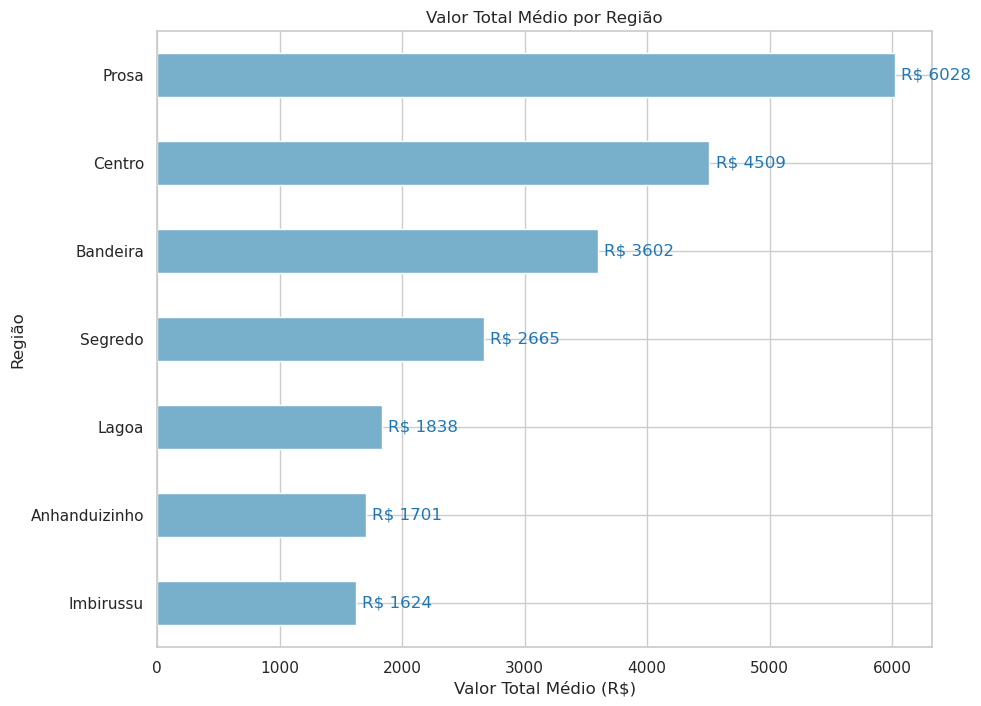

In [14]:
# 8. Valor Total Médio por Região
plt.figure(figsize=(10, 8))
regiao_media = df.groupby('regiao')['valor_total'].mean().sort_values(ascending=False)
regiao_media.plot(kind='barh', color='#78b0cc')
plt.title('Valor Total Médio por Região')
plt.xlabel('Valor Total Médio (R$)')
plt.ylabel('Região')
for i, v in enumerate(regiao_media):
    plt.text(v + 50, i, f'R$ {v:.0f}', va='center', color='#1f77b4')
plt.gca().invert_yaxis()
plt.show()

# Análise de correlação

/home/leandro/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


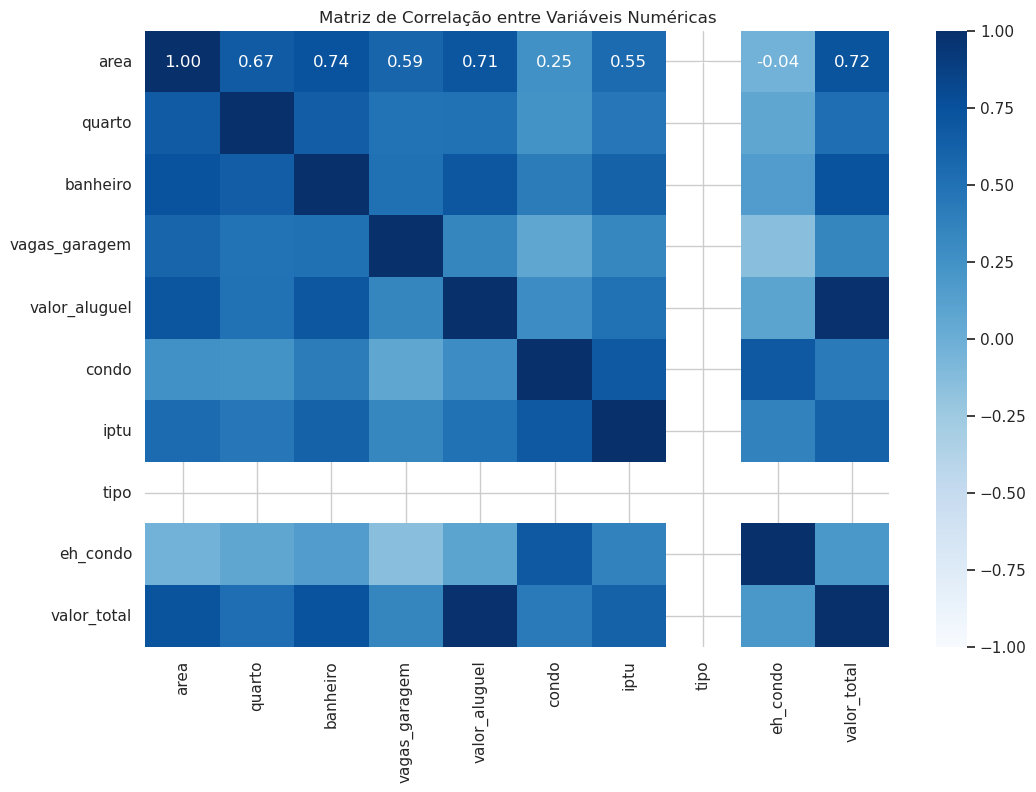

In [15]:
df_encoded = df.copy()
df_encoded['tipo'] = df_encoded['tipo'].map({'casa': 0, 'apartamento': 1})
df_encoded['eh_condo'] = df_encoded['eh_condo'].astype(int)

variaveis = ['area', 'quarto', 'banheiro', 'vagas_garagem', 'valor_aluguel', 
             'condo', 'iptu', 'tipo', 'eh_condo', 'valor_total']

corr = df_encoded[variaveis].corr()

# Plotar heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='Blues', center=0, vmin=-1, vmax=1)
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.show()

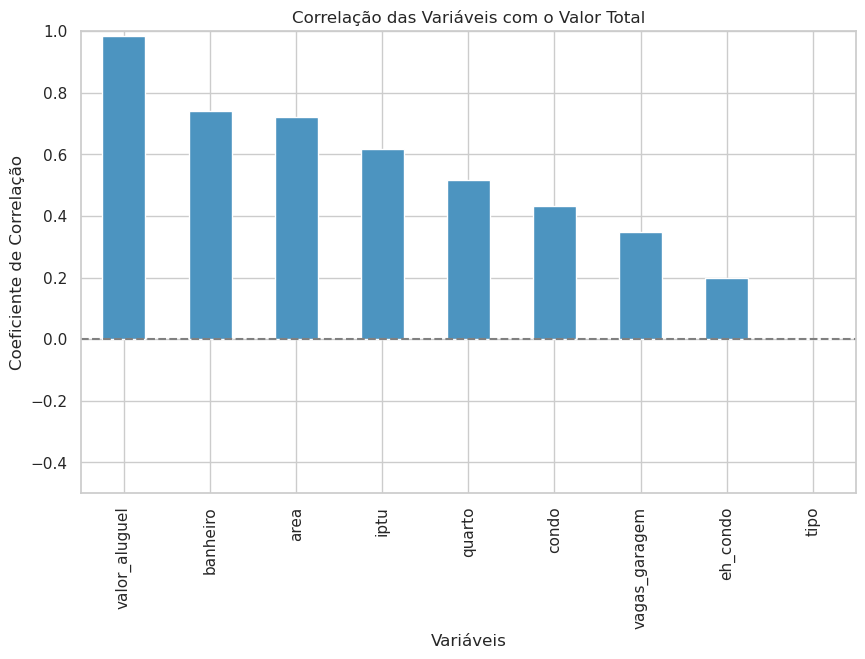

In [16]:
# Correlações com 'valor_total'
corr_valor_total = corr['valor_total'].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
corr_valor_total.drop('valor_total').plot(kind='bar', color='#4c94c0')
plt.title('Correlação das Variáveis com o Valor Total')
plt.xlabel('Variáveis')
plt.ylabel('Coeficiente de Correlação')
plt.ylim(-0.5, 1)
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

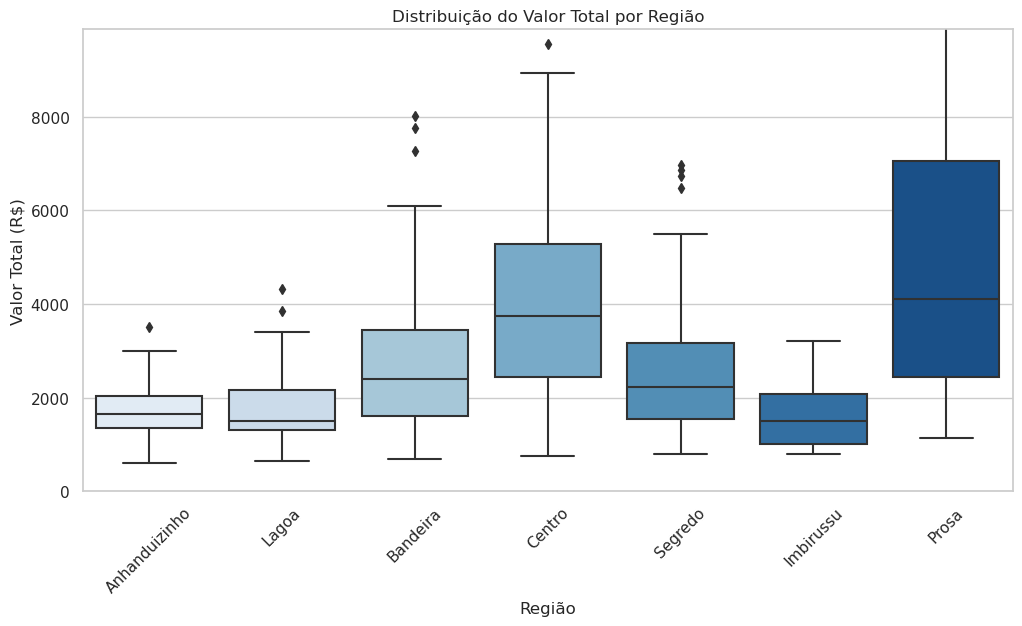

In [17]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='regiao', y='valor_total', data=df, palette='Blues')
plt.title('Distribuição do Valor Total por Região')
plt.xlabel('Região')
plt.ylabel('Valor Total (R$)')
plt.xticks(rotation=45)
plt.ylim(0, df['valor_total'].quantile(0.95))
plt.show()

# Pré-processamento

In [3]:
cat_cols = ['tipo', 'regiao', 'bairro', 'localizacao']
num_cols = ['area', 'quarto', 'banheiro', 'vagas_garagem', 'eh_condo']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

X = df.drop(columns=['valor_total', 'endereco'])
y = df['valor_total']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipelines

In [4]:
# Pipeline - SVR
pipeline_svr = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', SVR())
])

# Pipelines - DT
pipeline_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor())
])

# Pipeline - RF
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())
])

# Grades de hiperparâmetros
param_grid_svr = {
    'model__kernel': ['linear', 'rbf'],
    'model__C': [0.1, 1, 10],
    'model__epsilon': [0.1, 0.2]
}

param_grid_dt = {
    'model__max_depth': [None, 5, 10],
    'model__min_samples_split': [2, 5, 10]
}

param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 15, 20],
    'model__min_samples_split': [5, 10, 15],
    'model__max_features': ['sqrt', 'log2']
}

In [5]:
# GridSearch
grid_svr = GridSearchCV(pipeline_svr, param_grid_svr, cv=5, scoring='r2', n_jobs=-1)
grid_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='r2', n_jobs=-1)
grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='r2', n_jobs=-1)

grid_svr.fit(X_train, y_train)
grid_dt.fit(X_train, y_train)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['tipo',
                                                                          'regiao',
                                                                          'bairro',
                                                                          'localizacao']),
                                                                        ('num',
                                                                         'passthrough',
                                                                         ['area',
                                                                          'quarto',
                                                                          'banheiro',
                                                                          'vagas_garagem',
                                                                          'eh_condo'])])),
                                       ('model', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 15, 20],
                         'model__max_features': ['sqrt', 'log2'],
                         'model__min_samples_split': [5, 10, 15],
                         'model__n_estimators': [100, 200, 300]},
             scoring='r2')

In [6]:
def evaluate_best_model(grid, X_test, y_test):
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    print(f"Melhores Parâmetros: {grid.best_params_}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
    print(f"R²: {r2_score(y_test, y_pred):.2f}\n")

print("=== SVR ===")
evaluate_best_model(grid_svr, X_test, y_test)

print("=== Decision Tree ===")
evaluate_best_model(grid_dt, X_test, y_test)

print("=== Random Forest ===")
evaluate_best_model(grid_rf, X_test, y_test)

=== SVR ===
Melhores Parâmetros: {'model__C': 10, 'model__epsilon': 0.2, 'model__kernel': 'linear'}
MAE: 1292.72
MSE: 5311020.07
R²: 0.69

=== Decision Tree ===
Melhores Parâmetros: {'model__max_depth': None, 'model__min_samples_split': 10}
MAE: 1330.04
MSE: 6269719.62
R²: 0.63

=== Random Forest ===
Melhores Parâmetros: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_split': 5, 'model__n_estimators': 100}
MAE: 1069.66
MSE: 3245624.55
R²: 0.81



In [7]:
# Exemplo com Random Forest
best_rf = grid_rf.best_estimator_
scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='r2')
print(f"R² médio (Validação Cruzada): {scores.mean():.2f} (± {scores.std():.2f})")

R² médio (Validação Cruzada): 0.68 (± 0.04)


# Salvando o modelo

In [9]:
best_model = grid_rf.best_estimator_
joblib.dump(best_model, 'modelo_aluguel_rf.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']

# Predição

In [10]:
modelo = joblib.load('modelo_aluguel_rf.pkl')

In [11]:
def prever_aluguel():
    tipo = input("Tipo do imóvel (Casa/Apartamento): ").strip().lower()
    regiao = input("Região (Ex: Centro, Segredo...): ").strip()
    bairro = input("Bairro: ").strip()
    localizacao = input("Vila/Loteamento: ").strip()
    area = float(input("Área (m²): "))
    quarto = int(input("Número de quartos: "))
    banheiro = int(input("Número de banheiros: "))
    vagas_garagem = float(input("Vagas de garagem: "))
    eh_condo = int(input("Pertence a condomínio? (1-Sim / 0-Não): "))

    dados_input = pd.DataFrame([{
        'tipo': tipo,
        'regiao': regiao,
        'bairro': bairro,
        'localizacao': localizacao,
        'area': area,
        'quarto': quarto,
        'banheiro': banheiro,
        'vagas_garagem': vagas_garagem,
        'eh_condo': eh_condo
    }])

    valor_predito = modelo.predict(dados_input)[0]
    print(f"\nValor total estimado: R$ {valor_predito:.2f}")

In [14]:
prever_aluguel()


Valor total estimado: R$ 2328.51
